In [1]:
!pip install transformers==3.0.0

     |████████████████████████████████| 754 kB 1.2 MB/s 
     |████████████████████████████████| 3.0 MB 5.1 MB/s 
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.10.1
    Uninstalling tokenizers-0.10.1:
      Successfully uninstalled tokenizers-0.10.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.3.3
    Uninstalling transformers-4.3.3:
      Successfully uninstalled transformers-4.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.1.0 requires transformers<4.4,>=4.1, but you have transformers 3.0.0 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
df = pd.read_csv("../input/logdata/train.csv")
df.head()

,Exception (input),Queue,Process,Exception Category (ouput)
0,Invite not found in both CBS mailbox,Queue-12,Process-9,Business Exception
1,Interviewer xxxx mail ID not found in invite.,Queue-12,Process-9,Business Exception
2,Invite not found in both TAX and PAS mailbox,Queue-12,Process-9,Business Exception
3,InternalFailed to evaluate expression 'Replace...,Queue-14,Process-11,System Exception
4,Could not execute code stage because exception...,Queue-16,Process-13,System Exception


In [4]:
df = df.rename(columns={"Exception (input)":"text","Exception Category (ouput)":"label"})
df = df.replace("Business Exception",0)
df = df.replace("System Exception",1)
df.head()

,text,Queue,Process,label
0,Invite not found in both CBS mailbox,Queue-12,Process-9,0
1,Interviewer xxxx mail ID not found in invite.,Queue-12,Process-9,0
2,Invite not found in both TAX and PAS mailbox,Queue-12,Process-9,0
3,InternalFailed to evaluate expression 'Replace...,Queue-14,Process-11,1
4,Could not execute code stage because exception...,Queue-16,Process-13,1


In [5]:
df.shape

(47, 4)

In [6]:
# check class distribution
df['label'].value_counts(normalize = True)

1    0.617021
0    0.382979
Name: label, dtype: float64

In [7]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.1, 
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [8]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

<AxesSubplot:>

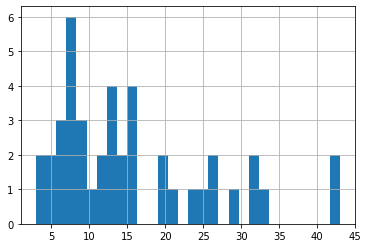

In [9]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [10]:
max_seq_len = 25

In [11]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

In [12]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [13]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [14]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [15]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [16]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [17]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [18]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[1.3125     0.80769231]


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1], y=42    1
25    0
1     0
37    1
28    1
9     0
4     1
44    1
17    0
6     1
46    1
29    1
40    1
26    1
31    0
35    0
36    1
39    1
33    1
16    0
43    1
11    1
5     0
15    1
41    1
12    0
14    1
38    1
8     0
0     0
7     1
22    0
30    1
18    0
23    1
27    0
45    1
20    1
32    1
21    1
19    0
13    0
Name: label, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [19]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 30

In [20]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [21]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [22]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 30

Evaluating...

Training Loss: 0.848
Validation Loss: 0.586

 Epoch 2 / 30

Evaluating...

Training Loss: 0.761
Validation Loss: 1.239

 Epoch 3 / 30

Evaluating...

Training Loss: 0.947
Validation Loss: 0.628

 Epoch 4 / 30

Evaluating...

Training Loss: 0.713
Validation Loss: 0.598

 Epoch 5 / 30

Evaluating...

Training Loss: 0.710
Validation Loss: 0.550

 Epoch 6 / 30

Evaluating...

Training Loss: 0.691
Validation Loss: 0.646

 Epoch 7 / 30

Evaluating...

Training Loss: 0.682
Validation Loss: 0.740

 Epoch 8 / 30

Evaluating...

Training Loss: 0.631
Validation Loss: 0.647

 Epoch 9 / 30

Evaluating...

Training Loss: 0.609
Validation Loss: 0.603

 Epoch 10 / 30

Evaluating...

Training Loss: 0.596
Validation Loss: 0.522

 Epoch 11 / 30

Evaluating...

Training Loss: 0.562
Validation Loss: 0.479

 Epoch 12 / 30

Evaluating...

Training Loss: 0.535
Validation Loss: 0.436

 Epoch 13 / 30

Evaluating...

Training Loss: 0.559
Validation Loss: 0.393

 Epoch 14 / 30

Eval

In [23]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [24]:
# get predictions for test data
with torch.no_grad():
  preds = model(train_seq.to(device), train_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [25]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(train_y, preds))

              precision    recall  f1-score   support

           0       0.93      0.81      0.87        16
           1       0.89      0.96      0.93        26

    accuracy                           0.90        42
   macro avg       0.91      0.89      0.90        42
weighted avg       0.91      0.90      0.90        42



In [26]:
# confusion matrix
pd.crosstab(train_y, preds)

col_0,0,1
row_0,,
0,13,3
1,1,25


In [27]:
def pipeline(text):
    token = tokenizer.batch_encode_plus(
            [text],
            max_length = max_seq_len,
            pad_to_max_length=True,
            truncation=True,
            return_token_type_ids=False
            )
    new_seq = torch.tensor(token['input_ids'])
    new_mask = torch.tensor(token['attention_mask'])
    return [new_seq, new_mask]

def predict(text):
    with torch.no_grad():
        data = pipeline(text)
        output = model(data[0].to(device), data[1].to(device))
        output = output.detach().cpu().numpy()
        return np.argmax(output,axis=1)

In [28]:
device = torch.device("cpu")
model = model.to(device)
print(predict("Error in populating result in output template - Unexpected error occured in running output  macro"))

[1]
